In [1]:
import sys, os, time, copy, gc
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
import torchvision

import numpy as np
import pandas as pd

import warnings

sys.path.append('../src')
from train import *
from models import *
from dataset import *
from pre_processing import *

/home/sushruth/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-11-01 09:14:06.013617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 09:14:06.669015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load a specific model

In [2]:
checkpoint_path = Path('../models')

In [3]:
checkpoint_file = "UNet_2024-11-01_08_37.pth"

In [4]:
checkpoint = torch.load(os.path.join(checkpoint_path,checkpoint_file))

/tmp/ipykernel_703523/714819904.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_path,checkpoint_file))


In [5]:
CONFIG = checkpoint['CONFIG']
train_loss = checkpoint['train_loss'] 
valid_loss = checkpoint['valid_loss']
lr_rate = checkpoint['lr_rate']

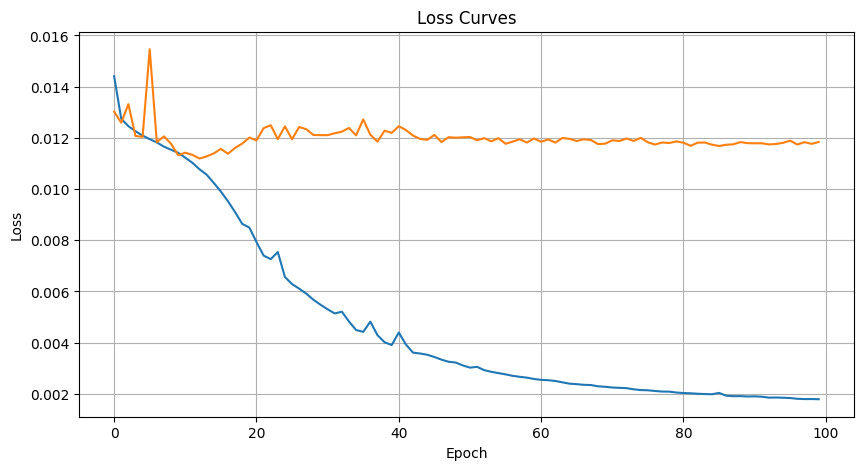

In [6]:
plot_loss_curve(train_loss, valid_loss)

## Set up model for Inference

In [7]:
#override device to cpu for inference
CONFIG['device'] = 'cpu'

In [8]:
model_infer = setup_model(CONFIG)
model_infer.load_state_dict(checkpoint['state_dict'])
#display_trainable_params(model_infer)

<All keys matched successfully>

## Import a dataset

In [9]:
data_path = Path('../datasets')

In [10]:
cifar_train_dataset = torchvision.datasets.CIFAR10(data_path, train=True, transform=None)
cifar_val_dataset = torchvision.datasets.CIFAR10(data_path, train=False, transform=None)

In [11]:
transform_in = getTransform_in(CONFIG)
transform_out = getTransform_out(CONFIG)

In [12]:
train_dataset = BuildImageDataset(cifar_train_dataset, transform_in=transform_in, transform_out=transform_out)
valid_dataset = BuildImageDataset(cifar_val_dataset, transform_in=transform_in, transform_out=transform_out)

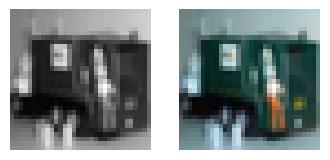

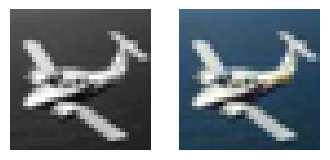

In [15]:
#idx_train = np.random.randint(0, len(train_dataset))
#idx_valid = np.random.randint(0, len(valid_dataset))
idx_train = 40063 
idx_valid = 5223
#Display random image from train dataset
train_dataset.display_img_pair(idx = idx_train,upscaling_factor=4)
#Display random image from train dataset
valid_dataset.display_img_pair(idx = idx_valid,upscaling_factor=4)

# Run Inference

In [16]:
input_train_img = train_dataset.__getitem__(idx_train)[0]
input_valid_img = valid_dataset.__getitem__(idx_valid)[0]
with torch.no_grad():
    out_train_img = model_infer(input_train_img.unsqueeze(0))
    out_valid_img = model_infer(input_valid_img.unsqueeze(0))

In [17]:

from skimage.color import lab2rgb
if CONFIG['OUT_COLORMAP'] == 'lab':
    # append grayscale to L channel of lab image and denormalize
    inf_train_img = torch.cat((input_train_img*100 +50,out_train_img.squeeze(0)*110), dim=0)
    inf_val_img = torch.cat((input_valid_img*100 +50,out_valid_img.squeeze(0)*110), dim=0)
    inf_train_img = np.transpose(inf_train_img,(1,2,0))
    inf_val_img = np.transpose(inf_val_img,(1,2,0))
    inf_train_img = lab2rgb(inf_train_img)
    inf_val_img = lab2rgb(inf_val_img)
else:
    #denormalize from transforms_basic
    inf_train_img = np.transpose(out_train_img.squeeze(0).detach(),(1,2,0))
    inf_val_img = np.transpose(out_valid_img.squeeze(0).detach(),(1,2,0))
    inf_train_img = inf_train_img/2 + 0.5
    inf_val_img = inf_val_img/2 + 0.5

/tmp/ipykernel_703523/3090089435.py:8: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 301 negative Z values that have been clipped to zero
  inf_train_img = lab2rgb(inf_train_img)
/tmp/ipykernel_703523/3090089435.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 198 negative Z values that have been clipped to zero
  inf_val_img = lab2rgb(inf_val_img)


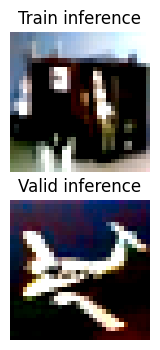

In [18]:
plt.figure(figsize=(4,4))
plt.subplot(2, 1, 1)
plt.imshow(inf_train_img, interpolation='nearest')
plt.title('Train inference')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(inf_val_img, interpolation='nearest')
plt.title('Valid inference')
plt.axis('off')
plt.show()

In [19]:
#List of clipped pixels in the image
clipped_pixels_train = np.transpose(np.where(inf_train_img > 1),(1,0))
clipped_pixels_val = np.transpose(np.where(inf_val_img > 1),(1,0))


In [20]:
print(len(clipped_pixels_val), len(clipped_pixels_train))

0 0
